In [1]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import argrelextrema
from scipy.fft import fftshift
import numpy as np
import itertools
import os
import pyaudio
from io import BytesIO

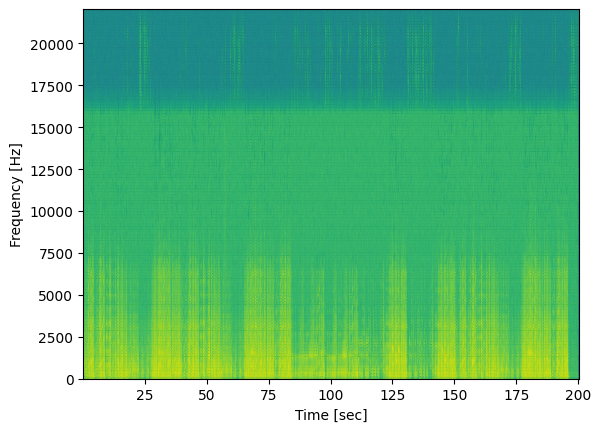

In [2]:
def describe_song(mp3):
    loaded_song = AudioSegment.from_mp3(mp3)
    raw_sample = loaded_song.get_array_of_samples()
    f, t, Sxx = signal.spectrogram(np.array(raw_sample), loaded_song.frame_rate)
    # To improve contrast, changing to a decibal scale
    plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
describe_song("./sample.mp3")

In [3]:
# Finds peaks when looking at both time and frequency dimensions. A previous iteration
# searched for peaks in a single time slice, without much luck. 
def extract_peaks(f, t, Sxx):
    frequency_bucket_size = 500
    frequency_buckets = np.int32(np.floor(f/frequency_bucket_size))
    time_bucket_size = 0.5
    time_buckets = np.int32(np.floor(t/time_bucket_size))
    peaks = [[], []]
    for t_itr in range(max(time_buckets)+1):
        for f_itr in range(max(frequency_buckets)+1):
            spectrogram_tile = Sxx[np.where(frequency_buckets == f_itr), :]
            spectrogram_tile = spectrogram_tile[:, :, np.where(time_buckets == t_itr)]
            tile_max = np.unravel_index(np.argmax(spectrogram_tile), spectrogram_tile.shape)
            peak = (np.where(frequency_buckets == f_itr)[0][tile_max[1]], 
                    np.where(time_buckets == t_itr)[0][tile_max[3]])
            # Removing uninteresting peaks
            if Sxx[peak[0], peak[1]] >= 1.0:
                peaks[0].append(peak[0])
                peaks[1].append(peak[1])
    return np.array([t[peaks[1]], f[peaks[0]]])

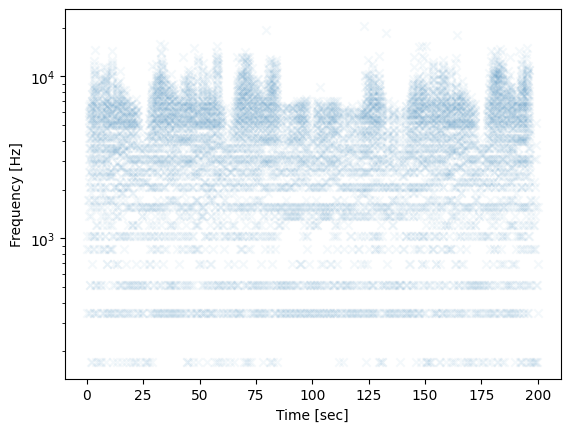

In [4]:
"""Peak locations for an entire song."""
def plot_peaks(mp3):
    loaded_song = AudioSegment.from_mp3(mp3)
    peak_points = extract_peaks(*signal.spectrogram(np.array(loaded_song.get_array_of_samples()), 
                                                    loaded_song.frame_rate))
    plt.scatter(peak_points[0,:], peak_points[1,:], marker='x', alpha=0.05)
    plt.yscale('log')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
plot_peaks("./sample.mp3")

In [5]:
# Relative to an anchor, return points within a target zone appropriate
# for fingerprint constellations.
def extract_target_zone(anchor_point, peak_points):
    target_t_interval = (anchor_point[0]+0.1, anchor_point[0]+2)
    target_f_interval = (max(0,anchor_point[1]-500), anchor_point[1]+500)

    target_t_indices = np.logical_and(
        target_t_interval[0] <= peak_points[0,:], 
        peak_points[0,:] <= target_t_interval[1],
    )
    target_f_indices = np.logical_and(
        target_f_interval[0] <= peak_points[1,:],
        peak_points[1,:] <= target_f_interval[1]
    )
    target_indices = np.where(np.logical_and(target_t_indices, target_f_indices))[0]
    return peak_points[:, target_indices]

def compute_target_zone_fingerprints(anchor_point, target_zone_points):
    fingerprints = []
    if target_zone_points is None:
        return fingerprints
    for i in range(target_zone_points.shape[1]):
        fingerprints.append((
            # anchor point frequency
            anchor_point[1], 
            # target zone point frequency
            target_zone_points[1,i], 
            # time delta to anchor point
            target_zone_points[0,i]-anchor_point[0],
            # offset into the song
            anchor_point[0]
        ))
    return fingerprints

def compute_fingerprints(f, t, Sxx):
    peak_points = extract_peaks(f, t, Sxx)
    fingerprints = []
    for i in range(peak_points.shape[1]):
        anchor_point = peak_points[:,i]
        fingerprints += compute_target_zone_fingerprints(anchor_point, 
                                                         extract_target_zone(anchor_point, peak_points))
    return fingerprints

In [6]:
# A fake database that's really just a python dictionary. 
def build_song_db(mp3s):    
    song_db = {}
    for mp3 in mp3s:
        print("adding song to database:", mp3)
        loaded_song = AudioSegment.from_mp3(mp3)
        for f in compute_fingerprints(*signal.spectrogram(np.array(loaded_song.get_array_of_samples()), 
                                       loaded_song.frame_rate)):
            # These fields can be packed into a 64 bit integer, providing a lean database index. 
            db_key = (f[0], f[1], f[2])
            if db_key in song_db:
                if mp3 in song_db[db_key]:
                    song_db[db_key][mp3].append(f[3])
                else:
                    song_db[db_key][mp3] = [f[3]]
            else:
                song_db[db_key] = {mp3: [f[3]]}
    return song_db

song_db = build_song_db(["song-1.mp3"])

adding song to database: song-1.mp3


In [7]:
# Given a sample, check the database for potential matches.
def check_db_for_matches(song_db, raw_sample, raw_sample_frame_rate):
    sample_fingerprints = compute_fingerprints(*signal.spectrogram(np.array(raw_sample), 
                                                                   raw_sample_frame_rate))

    matches = {}
    for sample_fingerprint in sample_fingerprints:
        db_key = (sample_fingerprint[0], sample_fingerprint[1], sample_fingerprint[2])
        if db_key in song_db:
            for song in song_db[db_key]:
                for db_song_time_offset in song_db[db_key][song]:
                    if song in matches:
                        matches[song]['sample_offsets'].append(sample_fingerprint[3])
                        matches[song]['song_offsets'].append(db_song_time_offset)
                    else:
                        matches[song] = {
                            'sample_offsets': [sample_fingerprint[3]],
                            'song_offsets': [db_song_time_offset],
                        }
    return matches

# This histogram places where the sample aligns with a complete song. 
def build_match_histogram(matches):
    matching_histogram = {}
    for song in matches:
        for t_tuple in zip(matches[song]['sample_offsets'], matches[song]['song_offsets']):
            offset = t_tuple[1] - t_tuple[0]
            if song in matching_histogram:
                if offset in matching_histogram[song]:
                    matching_histogram[song][offset] += 1
                else:
                    matching_histogram[song][offset] = 1
            else:
                matching_histogram[song] = {
                    offset: 1 
                }
    return matching_histogram

def plot_match_results(matches):
    matching_songs = sorted(list(matches.keys()))
    if len(matching_songs) == 0:
        print('no matching song')
        return
    fig, ax = plt.subplots(len(matching_songs), 2, figsize=(10,10))
    ax = np.reshape(ax, (-1, 2))
    fig.tight_layout()
    for i in range(len(matching_songs)):
        target_song = matching_songs[i]
        ax[i, 0].scatter(matches[target_song]['song_offsets'], 
                matches[target_song]['sample_offsets'], 
                marker='o', alpha=0.5)
        ax[i, 0].set_ylabel('Sample Time [sec]')
        ax[i, 0].set_xlabel('"{}" Database Time [sec]'.format(target_song))

        matching_histogram = build_match_histogram(matches)
        offsets = []
        offset_hit_count = []
        for offset in sorted(matching_histogram[target_song].keys()):
            offsets.append(offset)
            offset_hit_count.append(matching_histogram[target_song][offset])
        ax[i, 1].scatter(offsets, offset_hit_count, marker='o', alpha=0.5)
        ax[i, 1].set_ylabel('Match Count')
        ax[i, 1].set_xlabel('"{}" Time Delta [sec]'.format(target_song))
    plt.show()

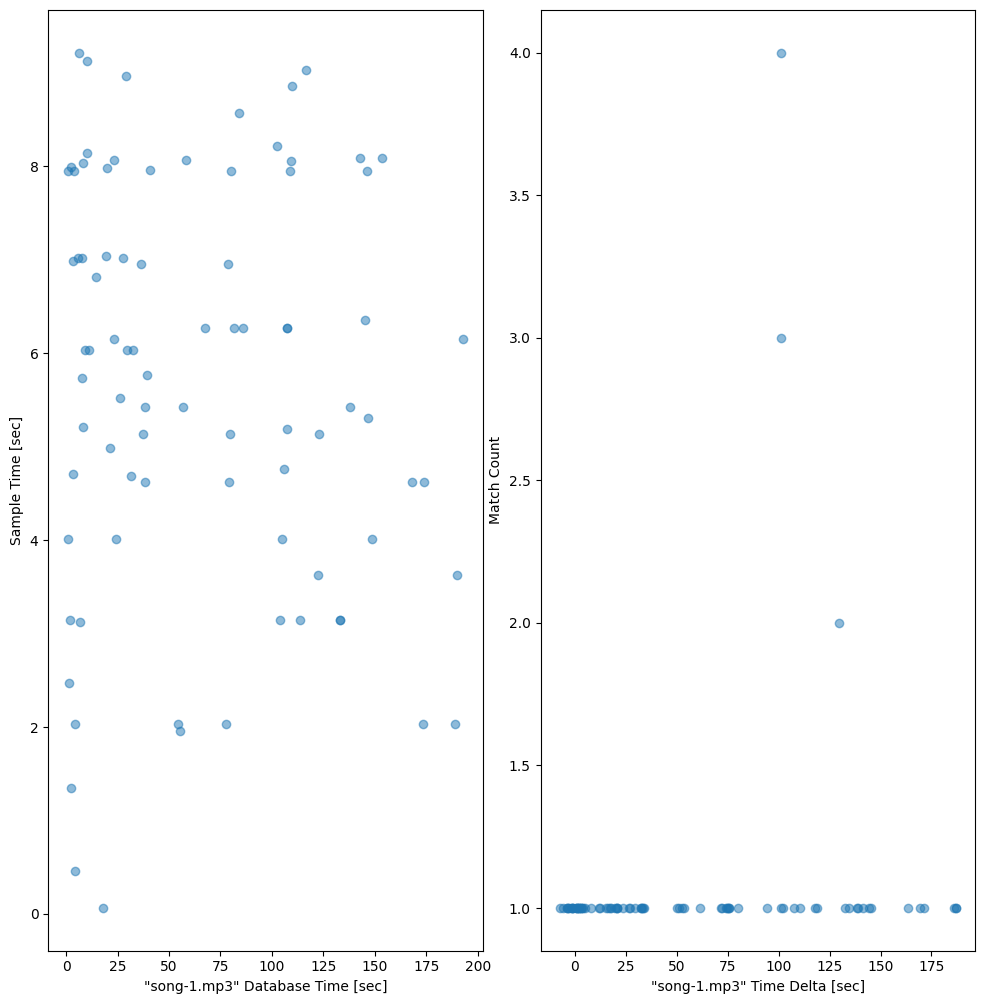

In [8]:
# TEST 1: does a sample of the only song in the database produce the expected matches? 
loaded_song = AudioSegment.from_mp3("song-1.mp3")
test_sample = loaded_song.get_array_of_samples()
matches = check_db_for_matches(song_db, test_sample[loaded_song.frame_rate*101:loaded_song.frame_rate*111],
                               loaded_song.frame_rate)
plot_match_results(matches)

In [9]:
# Let's now build a database with more songs present in the working directory.
song_db = build_song_db([f for f in  os.popen("ls").read().split('\n') if f.startswith("song")])

adding song to database: song-1.mp3
adding song to database: song-2.mp3
adding song to database: song-3.mp3
adding song to database: song-4.mp3
adding song to database: song-5.mp3
adding song to database: song-6.mp3


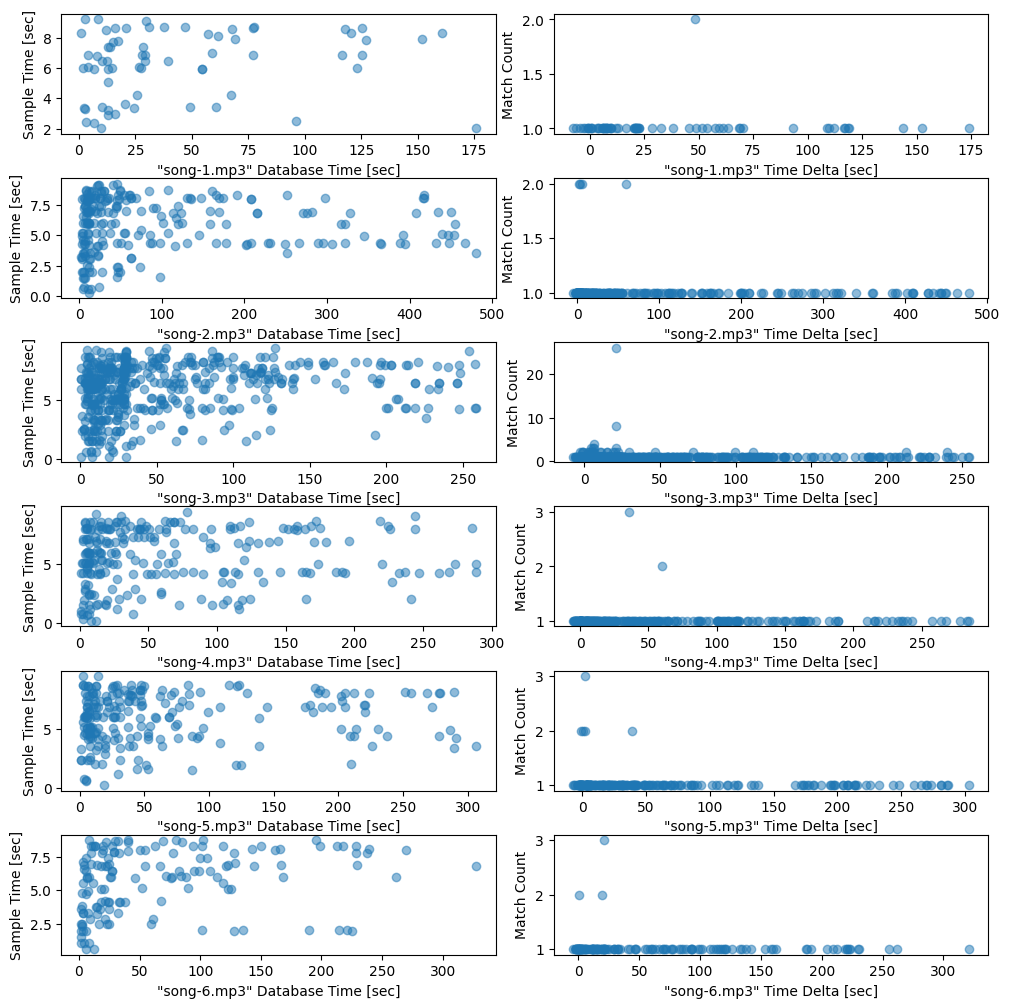

In [10]:
# TEST 2: does a perfect sample (extracted from a loaded song) 
# best match with a database having multiple songs?
test_song = AudioSegment.from_mp3("song-3.mp3")
test_sample = test_song.get_array_of_samples()
matches = check_db_for_matches(song_db, test_sample[test_song.frame_rate*21:test_song.frame_rate*31],
                               test_song.frame_rate)
plot_match_results(matches)

In [11]:
def record_from_mic(seconds):
    p = pyaudio.PyAudio()
    input_device = p.get_default_input_device_info()
    sample_rate = int(input_device['defaultSampleRate'])
    chunk_size = 1024
    stream = p.open(format=pyaudio.paInt16,
                    channels=2,
                    rate=sample_rate,
                    input=True,
                    frames_per_buffer=chunk_size)

    print("* recording")
    frames = []
    for i in range(0, int(sample_rate / chunk_size * seconds)):
        data = stream.read(chunk_size)
        frames.append(data)
    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    return {
        'data': np.frombuffer(b''.join(frames), dtype=np.int16), 
        'sample_rate': sample_rate
    }

# Debugging mic output
def save_mic_recording(sample):
    test_segment = AudioSegment.from_raw(
        BytesIO(recorded_sample['data']), 
        # Recorded with 16 bit integers, for a width of two bytes
        sample_width=2, 
        channels=2,
        frame_rate=recorded_sample['sample_rate']
    )
    test_segment.export("recording.mp3", format="mp3")

ALSA lib pcm_dsnoop.c:618:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1052:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.hdmi
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.hdmi
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.modem
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.modem
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.phoneline
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.phoneline
ALSA lib pcm_dmix.c:1052:(snd_pcm_dmix_open) unable to open slave


* recording
* done recording


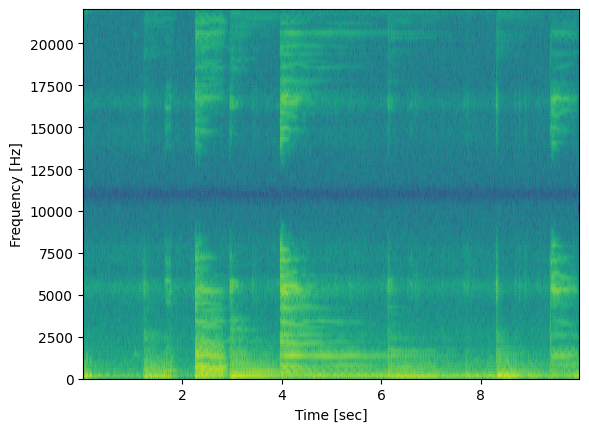

In [14]:
# Mic check: does the mic produce a spectrogram other than white noise?
recorded_sample = record_from_mic(5)
f, t, Sxx = signal.spectrogram(recorded_sample['data'], recorded_sample['sample_rate'])
# To improve contrast, changing to a decibal scale
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

ALSA lib pcm_dmix.c:1052:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib setup.c:547:(add_elem) Cannot obtain info for CTL elem (MIXER,'IEC958 Playback Default',0,0,0): No such file or directory
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.hdmi
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.hdmi
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.modem
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.modem
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.phoneline
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.phoneline
ALSA lib pcm_dmix.c:1052:(snd_pcm_dmix_open) unable to open slave


* recording
* done recording


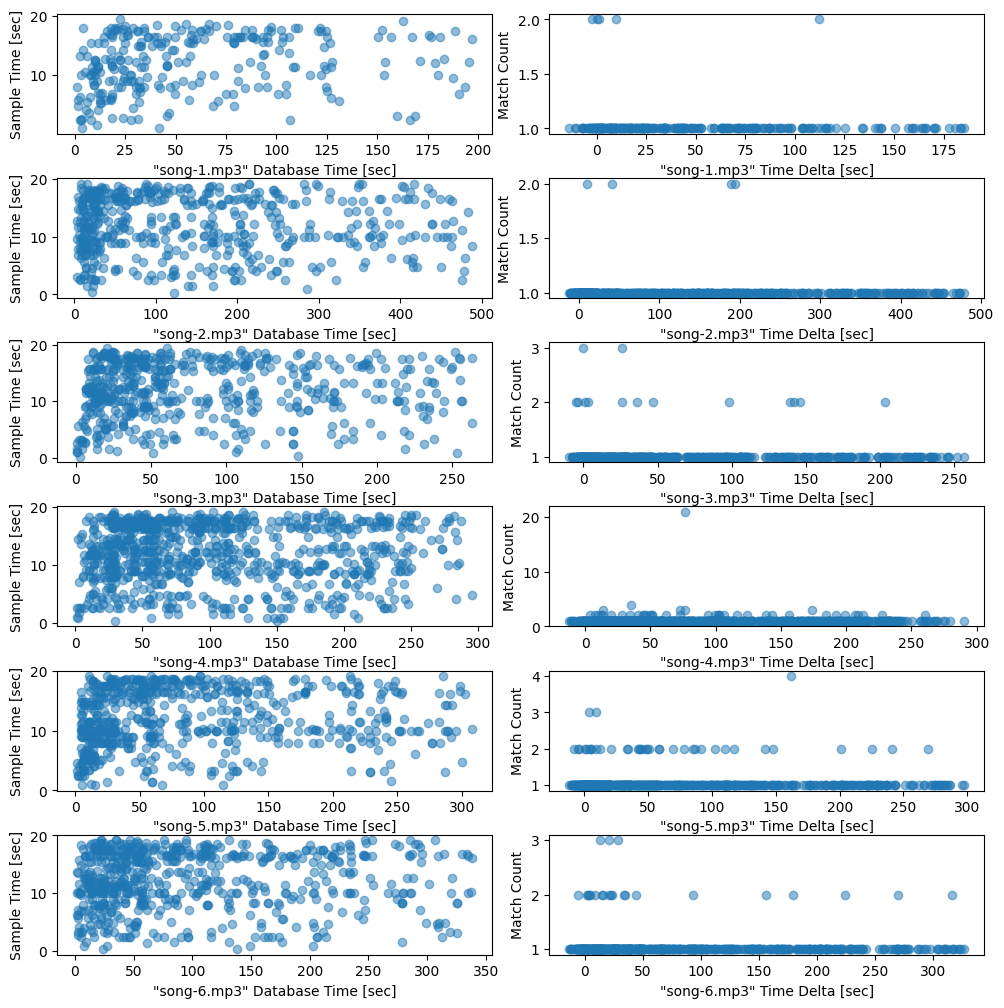

In [19]:
# Test 3: from a microphone input, do we get expected match results?
recorded_sample = record_from_mic(10)
save_mic_recording(recorded_sample)
matches = check_db_for_matches(song_db, recorded_sample['data'], recorded_sample['sample_rate'])
plot_match_results(matches)